# Source:
https://nlp.stanford.edu/projects/glove/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/genre_predictor

/content/drive/My Drive/genre_predictor


In [3]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import sklearn
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from datetime import datetime
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Download and Preprocess IMDb Movies Data
Download imdb movies data (imdb_movies.csv) from my other project about web scraping. Feel free to check it out at
https://github.com/KongpolC/web_scraping_with_beautifulsoup/blob/master/imbd_movies.csv

In [104]:
# Load .csv file to DataFrame
data = pd.read_csv('imdb_movies.csv')

In [113]:
# Create new DataFrame of ```features``` and ```labels```
imdb = data[['story','genre']]
imdb.dropna(inplace=True)

# Convert string in "genre" to array of genres
imdb['genre'] = imdb['genre'].apply(lambda x: np.array([genre.strip() for genre in x.split(',')]))
imdb


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,story,genre
0,Massimo is a member of the Sicilian Mafia fami...,"[Drama, Romance]"
1,Four African American vets battle the forces o...,"[Adventure, Drama, War]"
2,"Artemis Fowl, a young criminal prodigy, hunts ...","[Adventure, Family, Fantasy]"
3,Scott has been a case of arrested development ...,"[Comedy, Drama]"
4,A detective investigates the death of a patria...,"[Comedy, Crime, Drama]"
...,...,...
9995,The relationship between two friends deepens d...,"[Drama, Romance]"
9996,"After years abroad in Paris, Selma returns to ...",[Comedy]
9997,"When his father dies, a young man is introduce...","[Drama, Romance]"
9998,The Walmington-on-Sea Home Guard platoon deal ...,"[Comedy, War]"


# 2. Split into train and test set (80/20)

In [8]:
# def split_data(imdb, train_size=0.8, random_state=20):
    
#     # Shuffle rows
#     imdb = sklearn.utils.shuffle(imdb, random_state=random_state)

#     # Split
#     split_point = int(train_size*len(imdb))
#     train = imdb[:split_point]
#     test = imdb[split_point:]
    
#     return train, test

In [9]:
# train, test = split_data(imdb)

In [117]:
train, test = train_test_split(imdb, test_size=0.2, random_state=42)

# 3. Convert Data into Trainable Format

## 3.1 Feature (x)
Convert array of sentences (stories) to array of GloVe indices

### Download pretrained GloVe word vector representation
source: https://nlp.stanford.edu/projects/glove/

In [ ]:
# Download
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# Unzip
!unzip glove.6B.zip -d glove.6B

Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


### Convert sentences to GloVe indices
For explaination on implenting GloVe: link

In [10]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
            
    return words_to_index, index_to_words, word_to_vec_map

In [195]:
def get_max_seq_len(x, remove_stopwords=False):
    '''
    Finds maximum sequence length of a set of sentences to get a sense of what should be the max_seq_len
    
    Arguments:
    x -- input feature as array of sentences.
    remove_stopwords -- whether to remove stopwords or not.

    Returns:
    max_seq_len -- maximum sequence length of given sentences, x.
    '''
    
    max_seq_len = 0
    if remove_stopwords:
      for i in range(len(x)):
          max_seq_len = max( max_seq_len, len([word for word in word_tokenize(x[i].lower()) if word not in stopwords.words('english')]) )
    
    else:
      for i in range(len(x)):
          max_seq_len = max( max_seq_len, len(word_tokenize(x[i].lower())) )
        
    print('Maximum Sequence Length =', max_seq_len, 'words.')
    return max_seq_len

In [194]:
def sentences_to_indices(x, words_to_index, max_seq_len, remove_stopwords=False):
    '''
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.

    Arguments:
    x -- input feature as array of sentences.
    words_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)
    max_seq_len -- maximum sequence length of given sentences, x.
    remove_stopwords -- whether to remove stopwords or not.

    Returns:
    indices -- Array of indices corresponding words in sentences.
    '''

    # Get number of training examples
    m = x.shape[0]
    
    # Initialize "indices" as an array of zeros
    indices = np.zeros(shape=(m, max_seq_len))
    
    # Loop over examples
    if remove_stopwords:
      for i in tqdm(range(m), position=0, leave=True):
          sentence_words = [word for word in word_tokenize(x[i].lower()) if word not in stopwords.words('english')]
          
          j = 0
          for word in sentence_words:
              try:
                  indices[i,j] = words_to_index[word]
              except:
                  pass
              j += 1

    else:
      for i in tqdm(range(m), position=0, leave=True):
          sentence_words = word_tokenize(x[i].lower())
          
          j = 0
          for word in sentence_words:
              try:
                  indices[i,j] = words_to_index[word]
              except:
                  pass
              j += 1
            
    print(indices.shape)
    return indices

In [13]:
# Get GloVe Mappings
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B/glove.6B.50d.txt')

In [120]:
# Define x_train and x_test
x_train = np.asarray(train['story'])
x_test = np.asarray(test['story'])

In [221]:
# Find max_seq_len
max_seq_len_train = get_max_seq_len(x_train, remove_stopwords=True)
max_seq_len_test = get_max_seq_len(x_test, remove_stopwords=True)
max_seq_len = max(max_seq_len_train, max_seq_len_test)
print(max_seq_len)

Maximum Sequence Length = 54 words.
Maximum Sequence Length = 50 words.
54


In [222]:
# Convert sentences to word indices
x_train_indices = sentences_to_indices(x_train, word_to_index, max_seq_len, remove_stopwords=True)
x_test_indices = sentences_to_indices(x_test, word_to_index, max_seq_len, remove_stopwords=True)

  1%|          | 23/2000 [00:00<00:09, 215.84it/s]

(7997, 54)


100%|██████████| 2000/2000 [00:08<00:00, 231.09it/s]

(2000, 54)


## 3.2 Target (y)
Converts genres to one-hot vectors

In [17]:
def create_genre_to_label(imdb):
    '''
    Creates a dictionary mapping genres to class numbers.

    Arguments:
    imdb -- DataFrame of data.

    Returns:
    genre_to_label -- a dictionary mapping genres to class numbers.
    '''

    genres_count = []
    genres = []
    genre_to_label = {}

    for movie in imdb['genre']:
        for genre in movie:
            genres_count.append(genre)
            if genre not in genres:
                genres.append(genre)
                genre_to_label[genre] = len(genres) - 1

    print(genre_to_label)
    print('\n', Counter(genres_count))
    return genre_to_label

In [18]:
def to_one_hot(y, genre_to_label):
    '''
    Creates one hot vectors corresponding to labels(y) by converting class numbers to one hot vector

    Arguments:
    y -- DataFrame of labels
    genre_to_label -- a dictionary mapping genres to class numbers.

    Returns:
    one_hot_vector -- one hot vectors corresponding to y)
    '''

    one_hot_vector = np.zeros([len(y),len(genre_to_label)])
    
    for i in tqdm(range(len(y)), position=0, leave=True):
        for genre in y[i]:
            try:
                one_hot_vector[i][genre_to_label[genre]] = 1
            except:
                pass # print('ignored genre: ', genre)
    
    print(one_hot_vector.shape)
    return one_hot_vector

In [19]:
# Get one-hot mapping
genre_to_label = create_genre_to_label(imdb)

{'Crime': 0, 'Drama': 1, 'Thriller': 2, 'Action': 3, 'Sci-Fi': 4, 'Mystery': 5, 'Adventure': 6, 'Comedy': 7, 'Romance': 8, 'Horror': 9, 'Biography': 10, 'War': 11, 'Music': 12, 'Animation': 13, 'Fantasy': 14, 'Family': 15, 'Western': 16, 'History': 17, 'Sport': 18, 'Musical': 19, 'Film-Noir': 20}

 Counter({'Drama': 2597, 'Comedy': 1623, 'Action': 1375, 'Adventure': 1071, 'Thriller': 927, 'Crime': 899, 'Romance': 757, 'Horror': 624, 'Mystery': 503, 'Sci-Fi': 466, 'Fantasy': 441, 'Biography': 353, 'Family': 304, 'Animation': 248, 'History': 163, 'Music': 126, 'Sport': 103, 'War': 98, 'Musical': 74, 'Western': 69, 'Film-Noir': 17})


In [20]:
# Exclude low-occurence genres
del genre_to_label['Film-Noir']
del genre_to_label['Western']
del genre_to_label['Musical']
del genre_to_label['Sport']
del genre_to_label['War']
del genre_to_label['Music']
del genre_to_label['History']
del genre_to_label['Animation']
del genre_to_label['Family']
del genre_to_label['Biography']
del genre_to_label['Fantasy']

In [223]:
genre_to_label

{'Action': 3,
 'Adventure': 6,
 'Comedy': 7,
 'Crime': 0,
 'Drama': 1,
 'Horror': 9,
 'Mystery': 5,
 'Romance': 8,
 'Sci-Fi': 4,
 'Thriller': 2}

In [224]:
# Define y_train and y_test
y_train = np.asarray(train['genre'])
y_test = np.asarray(test['genre'])

In [225]:
# Convert to one-hot vectors
y_train_onehot = to_one_hot(y_train, genre_to_label)
y_test_onehot = to_one_hot(y_test, genre_to_label)

100%|██████████| 2000/2000 [00:00<00:00, 188030.57it/s]

(7997, 10)
(2000, 10)


# Modelling: Embedding and LSTM

In [126]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Create "Embedding Matrix"
    emb_matrix = np.zeros(shape=(vocab_size, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    # Create "Embedding Layer" using Keras
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [25]:
np.random.seed(0)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, RepeatVector, Lambda, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
np.random.seed(1)

In [247]:
def genre_predictor(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating genre_predictor normal LSTM model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """

    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)

    X = LSTM(128, return_sequences=True)(X)
    X = Dropout(0.5)(X)
    
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(64)(X)
    X = Activation('relu')(X)
    X = Dropout(0.4)(X)
    
    X = Dense(32)(X)
    X = Activation('relu')(X)
    X = Dropout(0.3)(X)
    
    X = Dense(10)(X) # 21
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    return model

# Trial run to find the optimal learning rate
Train the model and increase learning rate every epoch. Plot loss at each learning rate (each epoch) and choose the learning rate that gives lowest loss and is still stable. 

In [32]:
tf.random.set_seed(51)
np.random.seed(51)

In [59]:
#tf.keras.backend.clear_session()
trial_model = genre_predictor((max_seq_len,), word_to_vec_map, word_to_index)
#trial_model.summary()

# Define learning rate decay
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 5))

# Compile
opt = Adam(lr=1e-8, beta_1=0.9, beta_2=0.999)
trial_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Run
trial_history = trial_model.fit(x_train_indices, y_train_onehot, epochs=30, batch_size=32, shuffle=True, callbacks=[lr_schedule])

(1e-06, 1.0, 0.4, 0.8)

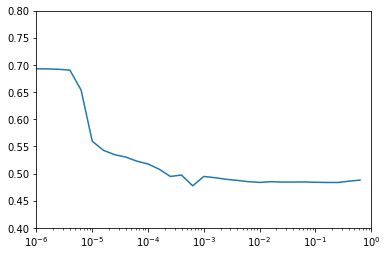

In [65]:
plt.semilogx(trial_history.history["lr"], trial_history.history["loss"])
plt.axis([1e-6, 1, 0.4, 0.8])

(1e-06, 1.0, 0.45, 0.55)

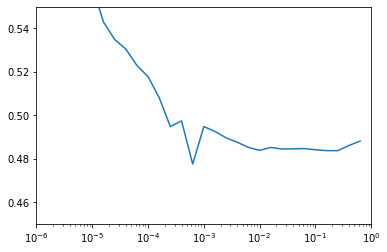

In [66]:
plt.semilogx(trial_history.history["lr"], trial_history.history["loss"])
plt.axis([1e-6, 1, 0.45, 0.55])

# Run with the obtained optimal learning rate

In [248]:
init_lr = 1e-3
decay_rate = 0.3

#tf.keras.backend.clear_session()
model = genre_predictor((max_seq_len,), word_to_vec_map, word_to_index)
model.summary()

# Define learning rate decay
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: init_lr/(1+decay_rate*epoch))

# Compile
opt = Adam(lr=init_lr, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 54)]              0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 54, 50)            20000050  
_________________________________________________________________
lstm_20 (LSTM)               (None, 54, 128)           91648     
_________________________________________________________________
dropout_50 (Dropout)         (None, 54, 128)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 54, 128)           131584    
_________________________________________________________________
dropout_51 (Dropout)         (None, 54, 128)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131

Create the callback `model_checkpoint_callback` which saves only the checkpoints. Therefore, don't have to worry about model getting worse as training goes.

In [249]:
# Crete callback to save only best checkpoints - add current time to folder name to avoid overwriting
time = datetime.now().strftime('_%H-%M-%S')

checkpoint_path = 'best_checkpoints'+time+'/'
os.mkdir(checkpoint_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',# val_auc_4 val_accuracy
    mode='max',
    save_best_only=True)

# Train the model
history = model.fit(x_train_indices, y_train_onehot, epochs=30, batch_size=32, shuffle=True, 
          validation_data=(x_test_indices, y_test_onehot), callbacks=[lr_schedule, model_checkpoint_callback])

Epoch 1/30
250/250 [==============================] - 21s 86ms/step - loss: 0.5046 - accuracy: 0.3619 - val_loss: 0.4546 - val_accuracy: 0.3960 - lr: 0.0010
Epoch 2/30
250/250 [==============================] - 23s 91ms/step - loss: 0.4594 - accuracy: 0.4140 - val_loss: 0.4380 - val_accuracy: 0.4375 - lr: 7.6923e-04
Epoch 3/30
250/250 [==============================] - 4s 17ms/step - loss: 0.4465 - accuracy: 0.4258 - val_loss: 0.4357 - val_accuracy: 0.4305 - lr: 6.2500e-04
Epoch 4/30
250/250 [==============================] - 4s 17ms/step - loss: 0.4390 - accuracy: 0.4393 - val_loss: 0.4336 - val_accuracy: 0.4090 - lr: 5.2632e-04
Epoch 5/30
250/250 [==============================] - 5s 18ms/step - loss: 0.4337 - accuracy: 0.4477 - val_loss: 0.4281 - val_accuracy: 0.4365 - lr: 4.5455e-04
Epoch 6/30
250/250 [==============================] - 20s 80ms/step - loss: 0.4284 - accuracy: 0.4487 - val_loss: 0.4262 - val_accuracy: 0.4535 - lr: 4.0000e-04
Epoch 7/30
250/250 [=====================

No handles with labels found to put in legend.
No handles with labels found to put in legend.


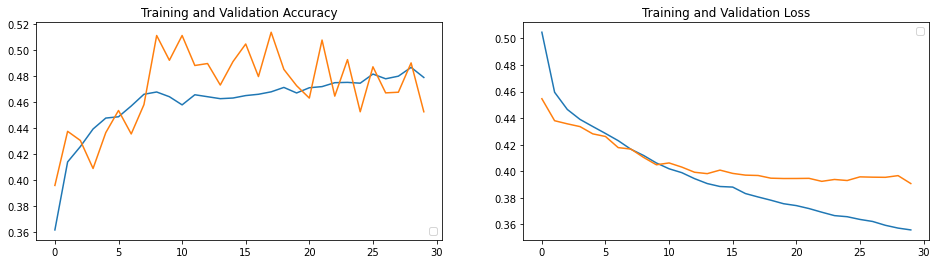

In [253]:
# Plot training history
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(checkpoint_path+'training_graph.jpg')
plt.show()

In [152]:
def benchmark(prediction, y_test_onehot, thresholds=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    '''
    Benchmark the model with micro-average quality numbers.

    Arguments:
    prediction -- Array of model's raw predictions.
    y_test_onehot -- Array of one-hot test labels.
    thresholds -- list of thresholds to examine.

    Returns:
    best_sigmoid_prediction = Array of sigmoid activated model's predictions where elements with values lower than threshold become 0, else become 1.
    '''

    print("Micro-average quality numbers")
    print('')

    max_f1 = 0
    for threshold in thresholds:

        # Apply sigmoid to predictions
        sigmoid_prediction = prediction.copy()
        sigmoid_prediction[sigmoid_prediction >= threshold] = 1
        sigmoid_prediction[sigmoid_prediction < threshold] = 0

        # Calculate precision, recall, and F1-score
        accuracy = accuracy_score(y_test_onehot, sigmoid_prediction)
        precision = precision_score(y_test_onehot, sigmoid_prediction, average='micro')
        recall = recall_score(y_test_onehot, sigmoid_prediction, average='micro')
        f1 = f1_score(y_test_onehot, sigmoid_prediction, average='micro')

        # Update max_f1
        if f1 > max_f1:
          max_f1 = f1
          best_sigmoid_prediction = sigmoid_prediction

        print("Threshold =", threshold)
        print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(accuracy, precision, recall, f1))
        print('')

    return best_sigmoid_prediction

In [251]:
best_model = tf.keras.models.load_model(checkpoint_path)
prediction = best_model.predict(x_test_indices)
prediction

array([[0.57586443, 0.47408897, 0.43190128, ..., 0.11150482, 0.00928209,
        0.15573974],
       [0.03715334, 0.6229104 , 0.05551941, ..., 0.5670546 , 0.44730732,
        0.04716378],
       [0.035802  , 0.44041067, 0.06797044, ..., 0.5981506 , 0.25986636,
        0.09963307],
       ...,
       [0.01113137, 0.8701848 , 0.0140211 , ..., 0.45898214, 0.49873376,
        0.00474878],
       [0.04026266, 0.5877276 , 0.06428782, ..., 0.57328033, 0.39095643,
        0.06174688],
       [0.03102167, 0.2385709 , 0.13685745, ..., 0.24941172, 0.00576519,
        0.15670937]], dtype=float32)

In [252]:
sigmoid_pred = benchmark(prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

Micro-average quality numbers

Threshold = 0.2
Accuracy: 0.0505, Precision: 0.4067, Recall: 0.8212, F1-measure: 0.5440

Threshold = 0.25
Accuracy: 0.0705, Precision: 0.4472, Recall: 0.7454, F1-measure: 0.5590

Threshold = 0.3
Accuracy: 0.1035, Precision: 0.4914, Recall: 0.6745, F1-measure: 0.5686

Threshold = 0.35
Accuracy: 0.1290, Precision: 0.5285, Recall: 0.5909, F1-measure: 0.5580

Threshold = 0.4
Accuracy: 0.1430, Precision: 0.5631, Recall: 0.5227, F1-measure: 0.5421

Threshold = 0.45
Accuracy: 0.1510, Precision: 0.6051, Recall: 0.4516, F1-measure: 0.5172

Threshold = 0.5
Accuracy: 0.1435, Precision: 0.6445, Recall: 0.3819, F1-measure: 0.4796



# Bidirectional LSTM with Attention Model

In [133]:
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, RepeatVector, Lambda, Flatten, Permute, Multiply, Conv1D, GlobalAveragePooling1D

In [226]:
def attention_genre_predictor(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating genre_predictor model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """

    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    X = Conv1D(filters=32, kernel_size=5, strides=1, padding="causal",activation="relu")(embeddings)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    #X = GlobalAveragePooling1D()(X)

    X = Bidirectional(LSTM(128, return_sequences=True))(X) # will have 256 units b/c it is bidirectional
    X = Dropout(0.5)(X)

    # Attention Layer
    #### Attention Cells
    A = Dense(1, activation='tanh')(X)
    A = Flatten()(A)
    A = Activation('softmax')(A)
    A = RepeatVector(256)(A)
    A = Permute([2, 1])(A)

    #### Merge X and Attention Cells to form context 
    X = Multiply()([X, A])
    X = Lambda(lambda xin: tf.keras.backend.sum(xin, axis=-2), output_shape=(128,))(X) # axis=-2
    X = Dropout(0.5)(X)

    # Output Layer
    X = Dense(10)(X) # 21
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    return model

In [227]:
init_lr = 1e-3
decay_rate = 0.3

#tf.keras.backend.clear_session()
attention_model = attention_genre_predictor((max_seq_len,), word_to_vec_map, word_to_index)
attention_model.summary()

# Define learning rate decay
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: init_lr/(1+decay_rate*epoch))

# Compile
opt = Adam(lr=init_lr, beta_1=0.9, beta_2=0.999)
attention_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # , tf.keras.metrics.AUC()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 54)]         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 54, 50)       20000050    input_21[0][0]                   
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 54, 32)       8032        embedding_20[0][0]               
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 54, 32)       0           conv1d_13[0][0]                  
___________________________________________________________________________________________

In [ ]:
# Crete callback to save only best checkpoints - add current time to folder name to avoid overwriting
time = datetime.now().strftime('_%H-%M-%S')

checkpoint_path = 'attention_best_checkpoints'+time+'/'
os.mkdir(checkpoint_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',# val_auc_4 val_accuracy
    mode='max',
    save_best_only=True)

# Train the model
attention_history = attention_model.fit(x_train_indices, y_train_onehot, epochs=30, batch_size=32, shuffle=True, 
          validation_data=(x_test_indices, y_test_onehot), callbacks=[lr_schedule, model_checkpoint_callback]) # lr_schedule

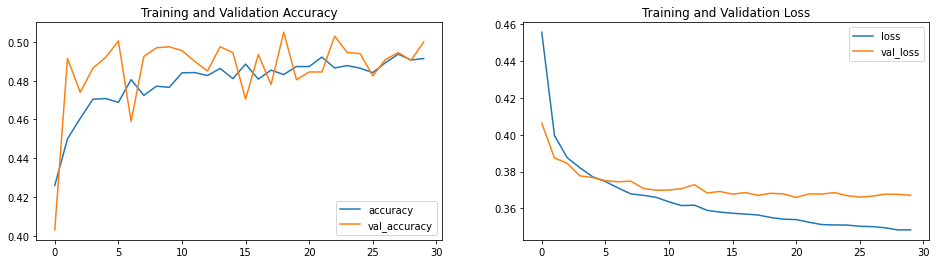

In [215]:
# Plot training history
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(attention_history.history['accuracy'], label='accuracy')
plt.plot(attention_history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(attention_history.history['loss'], label='loss')
plt.plot(attention_history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(checkpoint_path+'training_graph.jpg')
plt.show()

In [230]:
# Model's predictions
attention_best_model = tf.keras.models.load_model(checkpoint_path)
attention_best_prediction = attention_best_model.predict(x_test_indices)
attention_best_prediction

array([[0.9473312 , 0.4019208 , 0.63832307, ..., 0.11003352, 0.00452927,
        0.06951515],
       [0.1413038 , 0.4640138 , 0.22024249, ..., 0.55457264, 0.22005935,
        0.2922811 ],
       [0.06389438, 0.22551705, 0.02315038, ..., 0.88083375, 0.21768029,
        0.04812562],
       ...,
       [0.0979357 , 0.91473496, 0.05510943, ..., 0.38332242, 0.53307366,
        0.00966016],
       [0.11132425, 0.43983492, 0.21049199, ..., 0.41345218, 0.23093958,
        0.30252826],
       [0.05353102, 0.6517344 , 0.06046638, ..., 0.21568839, 0.12180372,
        0.03525869]], dtype=float32)

In [231]:
# Model's Benchmark
best_sigmoid_predictions = benchmark(attention_best_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,0.6,0.7])

Micro-average quality numbers

Threshold = 0.2
Accuracy: 0.0615, Precision: 0.4457, Recall: 0.8472, F1-measure: 0.5841

Threshold = 0.25
Accuracy: 0.0935, Precision: 0.4857, Recall: 0.8007, F1-measure: 0.6047

Threshold = 0.3
Accuracy: 0.1180, Precision: 0.5238, Recall: 0.7470, F1-measure: 0.6158

Threshold = 0.35
Accuracy: 0.1430, Precision: 0.5600, Recall: 0.6913, F1-measure: 0.6188

Threshold = 0.4
Accuracy: 0.1670, Precision: 0.5921, Recall: 0.6325, F1-measure: 0.6116

Threshold = 0.45
Accuracy: 0.1935, Precision: 0.6293, Recall: 0.5829, F1-measure: 0.6052

Threshold = 0.5
Accuracy: 0.1870, Precision: 0.6618, Recall: 0.5154, F1-measure: 0.5795

Threshold = 0.6
Accuracy: 0.1670, Precision: 0.7258, Recall: 0.3940, F1-measure: 0.5107

Threshold = 0.7
Accuracy: 0.1295, Precision: 0.7802, Recall: 0.2818, F1-measure: 0.4140



## Further Improvement to try
- Word Stemming
- changing model's hyperparameter

# Resource
- Deep Learning Specialization, Deeplearning.ai
- https://stackoverflow.com/questions/42918446/how-to-add-an-attention-mechanism-in-keras

In [ ]:
# Best according to AUC metrics >> still worse
best_sigmoid_predictions = benchmark(attention_best_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,0.6,0.7])

Micro-average quality numbers

Threshold = 0.2
Accuracy: 0.0605, Precision: 0.4672, Recall: 0.8035, F1-measure: 0.5908

Threshold = 0.25
Accuracy: 0.0955, Precision: 0.5030, Recall: 0.7473, F1-measure: 0.6013

Threshold = 0.3
Accuracy: 0.1270, Precision: 0.5364, Recall: 0.6889, F1-measure: 0.6032

Threshold = 0.35
Accuracy: 0.1545, Precision: 0.5687, Recall: 0.6294, F1-measure: 0.5975

Threshold = 0.4
Accuracy: 0.1620, Precision: 0.5953, Recall: 0.5680, F1-measure: 0.5813

Threshold = 0.45
Accuracy: 0.1635, Precision: 0.6262, Recall: 0.5120, F1-measure: 0.5634

Threshold = 0.5
Accuracy: 0.1615, Precision: 0.6604, Recall: 0.4532, F1-measure: 0.5375

Threshold = 0.6
Accuracy: 0.1415, Precision: 0.7220, Recall: 0.3380, F1-measure: 0.4604

Threshold = 0.7
Accuracy: 0.1200, Precision: 0.7836, Recall: 0.2343, F1-measure: 0.3607



In [ ]:
# new best test >> dropout(0.5)
benchmark(attention_best_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

Micro-average quality numbers

Threshold = 0.2
Precision: 0.4775, Recall: 0.7576, F1-measure: 0.5858

Threshold = 0.25
Precision: 0.5144, Recall: 0.7030, F1-measure: 0.5941

Threshold = 0.3
Precision: 0.5471, Recall: 0.6526, F1-measure: 0.5952

Threshold = 0.35
Precision: 0.5801, Recall: 0.5990, F1-measure: 0.5894

Threshold = 0.4
Precision: 0.6103, Recall: 0.5454, F1-measure: 0.5760

Threshold = 0.45
Precision: 0.6459, Recall: 0.5000, F1-measure: 0.5637

Threshold = 0.5
Precision: 0.6680, Recall: 0.4473, F1-measure: 0.5358



In [ ]:
# new best test
benchmark(attention_best_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

Micro-average quality numbers

Threshold = 0.2
Precision: 0.4744, Recall: 0.7773, F1-measure: 0.5892

Threshold = 0.25
Precision: 0.5086, Recall: 0.7168, F1-measure: 0.5950

Threshold = 0.3
Precision: 0.5435, Recall: 0.6609, F1-measure: 0.5965

Threshold = 0.35
Precision: 0.5727, Recall: 0.6031, F1-measure: 0.5875

Threshold = 0.4
Precision: 0.6116, Recall: 0.5577, F1-measure: 0.5834

Threshold = 0.45
Precision: 0.6350, Recall: 0.5000, F1-measure: 0.5595

Threshold = 0.5
Precision: 0.6588, Recall: 0.4496, F1-measure: 0.5345



In [114]:
# new test
benchmark(attention_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

Micro-average quality numbers

Threshold = 0.2
Precision: 0.4408, Recall: 0.7924, F1-measure: 0.5665

Threshold = 0.25
Precision: 0.4876, Recall: 0.7319, F1-measure: 0.5853

Threshold = 0.3
Precision: 0.5250, Recall: 0.6645, F1-measure: 0.5866

Threshold = 0.35
Precision: 0.5608, Recall: 0.5985, F1-measure: 0.5790

Threshold = 0.4
Precision: 0.5887, Recall: 0.5321, F1-measure: 0.5590

Threshold = 0.45
Precision: 0.6223, Recall: 0.4734, F1-measure: 0.5377

Threshold = 0.5
Precision: 0.6453, Recall: 0.4070, F1-measure: 0.4992



In [115]:
attention_prediction

array([[0.01456577, 0.11779842, 0.04227675, ..., 0.39102802, 0.02792817,
        0.15922509],
       [0.90657526, 0.44413835, 0.52538395, ..., 0.1705661 , 0.01070006,
        0.03614031],
       [0.07171665, 0.5293828 , 0.1731314 , ..., 0.44134486, 0.20071365,
        0.10602516],
       ...,
       [0.0405088 , 0.5359892 , 0.42912135, ..., 0.11777847, 0.12356661,
        0.61580056],
       [0.1928437 , 0.46987233, 0.30136222, ..., 0.11010281, 0.07112664,
        0.28915912],
       [0.01552584, 0.90675324, 0.04636701, ..., 0.10831106, 0.26429707,
        0.06653089]], dtype=float32)

In [ ]:
# sum on -1 axis, lambda 128 units
benchmark(attention_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

Micro-average quality numbers

Threshold = 0.2
Precision: 0.4075, Recall: 0.7388, F1-measure: 0.5253

Threshold = 0.25
Precision: 0.4454, Recall: 0.6480, F1-measure: 0.5279

Threshold = 0.3
Precision: 0.4808, Recall: 0.5788, F1-measure: 0.5253

Threshold = 0.35
Precision: 0.5232, Recall: 0.5170, F1-measure: 0.5201

Threshold = 0.4
Precision: 0.5603, Recall: 0.4643, F1-measure: 0.5078

Threshold = 0.45
Precision: 0.5891, Recall: 0.4120, F1-measure: 0.4849

Threshold = 0.5
Precision: 0.6028, Recall: 0.3588, F1-measure: 0.4499



In [ ]:
# sum on -1 axis, lambda 256 units
benchmark(attention_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

Micro-average quality numbers

Threshold = 0.2
Precision: 0.3913, Recall: 0.7324, F1-measure: 0.5101

Threshold = 0.25
Precision: 0.4338, Recall: 0.6535, F1-measure: 0.5215

Threshold = 0.3
Precision: 0.4703, Recall: 0.5765, F1-measure: 0.5180

Threshold = 0.35
Precision: 0.5070, Recall: 0.5119, F1-measure: 0.5095

Threshold = 0.4
Precision: 0.5317, Recall: 0.4349, F1-measure: 0.4784

Threshold = 0.45
Precision: 0.5611, Recall: 0.3556, F1-measure: 0.4353

Threshold = 0.5
Precision: 0.5777, Recall: 0.2796, F1-measure: 0.3768



In [ ]:
# sum on -2 axis, lambda 256 units
benchmark(attention_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

Micro-average quality numbers

Threshold = 0.2
Precision: 0.4572, Recall: 0.7823, F1-measure: 0.5771

Threshold = 0.25
Precision: 0.4927, Recall: 0.7154, F1-measure: 0.5836

Threshold = 0.3
Precision: 0.5242, Recall: 0.6544, F1-measure: 0.5821

Threshold = 0.35
Precision: 0.5584, Recall: 0.5894, F1-measure: 0.5735

Threshold = 0.4
Precision: 0.5882, Recall: 0.5197, F1-measure: 0.5518

Threshold = 0.45
Precision: 0.6142, Recall: 0.4610, F1-measure: 0.5267

Threshold = 0.5
Precision: 0.6459, Recall: 0.4079, F1-measure: 0.5000



In [ ]:
# sum on -2 axis, lambda 128 units
benchmark(attention_prediction, y_test_onehot, thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

Micro-average quality numbers

Threshold = 0.2
Precision: 0.4513, Recall: 0.7915, F1-measure: 0.5748

Threshold = 0.25
Precision: 0.4852, Recall: 0.7223, F1-measure: 0.5805

Threshold = 0.3
Precision: 0.5135, Recall: 0.6558, F1-measure: 0.5760

Threshold = 0.35
Precision: 0.5530, Recall: 0.5880, F1-measure: 0.5700

Threshold = 0.4
Precision: 0.5890, Recall: 0.5261, F1-measure: 0.5558

Threshold = 0.45
Precision: 0.6286, Recall: 0.4661, F1-measure: 0.5353

Threshold = 0.5
Precision: 0.6548, Recall: 0.4060, F1-measure: 0.5013

